## Zillow Sales versus List prices weekly for major US cities

In [56]:
# Loading in the basics
import psycopg2
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.svm import SVR
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [57]:
# Connect to postgres db
ENDPOINT="ucb-data-group-project-zillow.csaw135fqqkl.us-west-1.rds.amazonaws.com"
PORT="5432"
USR="postgres"
REGION="us-west-1"


In [58]:
DBNAME="postgres"

conn = psycopg2.connect(database = DBNAME,
                        user =     USR,
                        password = "aldavidethanjohn",
                        host =     ENDPOINT,
                        port =     PORT)

In [59]:
# list table sql
list_sql = '''
            SELECT *
            FROM list;
            '''

In [60]:
# sale table sql
sale_sql = '''
            SELECT *
            FROM sale;
            '''

In [61]:
# setting up dfs
list_df = pd.read_sql(list_sql, conn)
sale_df = pd.read_sql(sale_sql, conn)

In [62]:
# inspect list df
list_df.head()

,region_date,region_id,size_rank,region_name,region_type,state_name,date,price
0,10200120171104,102001,0,United States,Country,None,2017-11-04,275448.0
1,39491320171104,394913,1,"New York, NY",Msa,NY,2017-11-04,526850.0
2,75389920171104,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,2017-11-04,812252.0
3,39446320171104,394463,3,"Chicago, IL",Msa,IL,2017-11-04,319556.0
4,39451420171104,394514,4,"Dallas-Fort Worth, TX",Msa,TX,2017-11-04,347537.0


In [63]:
# inspect sale df
sale_df.head()

,region_date,region_id,size_rank,region_name,region_type,state_name,date,price
0,10200120080223,102001,0,United States,Country,None,2008-02-23,191138.0
1,39491320080223,394913,1,"New York, NY",Msa,NY,2008-02-23,NaN
2,75389920080223,753899,2,"Los Angeles-Long Beach-Anaheim, CA",Msa,CA,2008-02-23,516750.0
3,39446320080223,394463,3,"Chicago, IL",Msa,IL,2008-02-23,247988.0
4,39451420080223,394514,4,"Dallas-Fort Worth, TX",Msa,TX,2008-02-23,143466.0


In [64]:
# general cleaning
sale_df = sale_df.drop(["region_date","region_id","region_type"],1)
list_df = list_df.drop(["region_date","region_id", "region_type"],1)
list_df.head()

,size_rank,region_name,state_name,date,price
0,0,United States,None,2017-11-04,275448.0
1,1,"New York, NY",NY,2017-11-04,526850.0
2,2,"Los Angeles-Long Beach-Anaheim, CA",CA,2017-11-04,812252.0
3,3,"Chicago, IL",IL,2017-11-04,319556.0
4,4,"Dallas-Fort Worth, TX",TX,2017-11-04,347537.0


In [65]:
# us data pullout for list and sales data

us_list = list_df.loc[list_df["region_name"] == "United States"]
us_list = us_list.drop(["size_rank", "state_name"], 1)
us_sale = sale_df.loc[sale_df["region_name"] == "United States"]
us_sale = us_sale.drop(["size_rank", "state_name"],1)

us_sale.head()

,region_name,date,price
0,United States,2008-02-23,191138.0
128,United States,2020-10-31,290550.0
199,United States,2008-03-01,192225.0
296,United States,2008-03-08,192225.0
393,United States,2008-03-15,192475.0


In [69]:
# prepping us dfs for merge and merging
us_list = us_list.rename(columns = {"price":"list price"})
us_sale = us_sale.rename(columns = {"price":"sale price"})

us_df = us_list.merge(us_sale, on = ["region_name","date"], how = "right")
us_df = us_df.dropna()
# confirming date is datetime and using date as index
us_df["date"] = pd.to_datetime(us_df["date"])
us_df = us_df.set_index("date").sort_index()
us_df.head()

,region_name,list price,sale price
date,,,
2017-11-04,United States,275448.0,235099.0
2017-11-11,United States,275448.0,234750.0
2017-11-18,United States,275448.0,235750.0
2017-11-25,United States,274975.0,235916.0
2017-12-02,United States,274825.0,237166.0


In [92]:
us_df.shape

(186, 5)

In [97]:
us_df["list/sale percent diff"] = (us_df["list price"] / us_df["sale price"]) * 100
us_df["list/sale actual diff"] = (us_df["list price"] - us_df["sale price"])
us_df.drop_duplicates
us_df.shape


(186, 5)

<AxesSubplot:xlabel='date'>

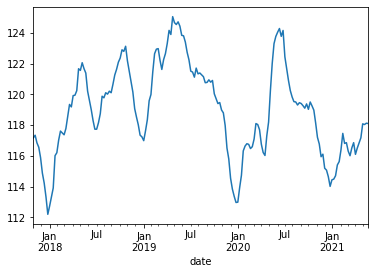

In [75]:
# examining the relation between list and sale
us_df["list/sale percent diff"].plot(x= "date")

<AxesSubplot:xlabel='date'>

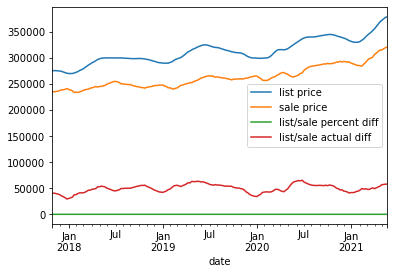

In [103]:
us_df.plot()

In [104]:
# https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1 
import sklearn.metrics as metrics

def regression_results(y_true, y_pred):
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [105]:
X_train = us_df.drop(['sale price'], axis = 1)
y_train = us_df.loc[:"2018", 'sale price']
X_test = us_df.drop(['sale price'], axis = 1)
y_test = us_df.loc['sale price']

KeyError: 'sale price'

D:\anaconda\envs\mlenv\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda\envs\mlenv\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda\envs\mlenv\lib\site-packages\sklearn\linear_model\_base.py", line 518, in fit
    X, y = self._validate_data(X, y, accept_sparse=accept_sparse,
  File "D:\anaconda\envs\mlenv\lib\site-packages\sklearn\base.py", line 433, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "D:\anaconda\envs\mlenv\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "D:\anaconda\envs\mlenv\lib\site-packages\sklearn\utils\validation.py", line 871, in check_X_y
    X = check_array(X, accept_sparse=accept_spars

LR: nan (nan)
NN: nan (nan)
KNN: nan (nan)
RF: nan (nan)


D:\anaconda\envs\mlenv\lib\site-packages\sklearn\model_selection\_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "D:\anaconda\envs\mlenv\lib\site-packages\sklearn\model_selection\_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "D:\anaconda\envs\mlenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 673, in fit
    return self._fit(X, y, incremental=False)
  File "D:\anaconda\envs\mlenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 364, in _fit
    X, y = self._validate_input(X, y, incremental, reset=first_pass)
  File "D:\anaconda\envs\mlenv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 1414, in _validate_input
    X, y = self._validate_data(X, y, accept_sparse=['csr', 'csc'],
  File "D:\anaconda\envs\mlenv\lib\

SVR: nan (nan)


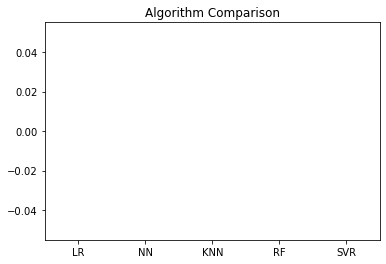

In [96]:
models = []
models.append(('LR', LinearRegression()))
models.append(('NN',  MLPRegressor(solver = 'lbfgs')))  #neural network
models.append(('KNN', KNeighborsRegressor())) 
models.append(('RF', RandomForestRegressor(n_estimators = 10))) # Ensemble method - collection of many decision trees
models.append(('SVR', SVR(gamma='auto'))) # kernel = linear
# Evaluate each model in turn
results = []
names = []
for name, model in models:
    # TimeSeries Cross validation
 tscv = TimeSeriesSplit(n_splits=8)
    
 cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring='r2')
 results.append(cv_results)
 names.append(name)
 print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))
    
# Compare Algorithms
plt.boxplot(results, labels=names)
plt.title('Algorithm Comparison')
plt.show()